In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jbcse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jbcse\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jbcse\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
data = pd.read_csv('comments.csv', sep=',', header=0)
data.head()

data[data['Is Reply'] == True][1300:1310]

,Comments,Comment ID,Reply Count,Is Reply,Author,AuthorID
2537,👆👆👆\nThanks for watching and leaving a comment...,Ugw2NYiIjCiRnr5mUpx4AaABAg.9aMePefk-wu9aMh9GrQhE0,0,True,Telegram@👉👉mrbeast770,UCwgMHGG8IDcYjjSXtYbE9rQ
2538,Congratulations you have been selected amongst...,Ugw2NYiIjCiRnr5mUpx4AaABAg.9aMePefk-wu9aMefMoxJJh,0,True,TELEGRAM 👉 MRBEAST6688,UCOqxwnL0H8oCTHlBNO9uSGQ
2540,👆👆👆\nThanks for watching and leaving a comment...,UgzjDdzgbDNfewCcgDt4AaABAg.9aMeN7_EuE49aMhIHnRt_M,0,True,Telegram@👉👉mrbeast770,UCwgMHGG8IDcYjjSXtYbE9rQ
2542,Congratulations you have been selected amongst...,UgyTmxKtlsBG3GDOW1x4AaABAg.9aMdm3Zkln99aMeGjHL_3I,0,True,TELEGRAM 👉 MRBEAST6688,UCOqxwnL0H8oCTHlBNO9uSGQ
2544,👆👆👆\nThanks for watching and leaving a comment...,UgyXisXjRZrctz-CbRB4AaABAg.9aMdLQlECGh9aMhacrkx89,0,True,Telegram@👉👉mrbeast770,UCwgMHGG8IDcYjjSXtYbE9rQ
2546,👆👆👆\nThanks for watching and leaving a comment...,Ugwqas8o6Pyp3EsSYI54AaABAg.9aMcvfgRaUA9aMhjlZooGS,0,True,Telegram@👉👉mrbeast770,UCwgMHGG8IDcYjjSXtYbE9rQ
2547,Congratulations you have been selected amongst...,Ugwqas8o6Pyp3EsSYI54AaABAg.9aMcvfgRaUA9aMd4F67uBs,0,True,TELEGRAM 👉 MRBEAST6688,UCOqxwnL0H8oCTHlBNO9uSGQ
2549,Congratulations you have been selected amongst...,UgyvVKPc9cIMrSF0gXh4AaABAg.9aMc_lWesUB9aMcg3T2VBB,0,True,TELEGRAM 👉 MRBEAST6688,UCOqxwnL0H8oCTHlBNO9uSGQ
2551,Inbox me to claim yours,UgwPBW2kYkJFMl9Mled4AaABAg.9aMcL7oR_0s9aMdFBjyt4n,0,True,TELEGRAM 👉 MRBEAST6688,UCOqxwnL0H8oCTHlBNO9uSGQ
2552,Are you the real mr beast,UgwPBW2kYkJFMl9Mled4AaABAg.9aMcL7oR_0s9aMcxRAs7DY,0,True,Yasanda Ransilu,UCMfTLkkdd0yFLVxkI1Dcxjw


In [7]:
scamChannels = ['UCwgMHGG8IDcYjjSXtYbE9rQ', 'UCIAYvaVP15Cel4NZ1ib_ADA', 'UC8Oy99fOvCjHfbvTImDXpkg',
'UCswOElw6g7pEeAA5Mu15p3Q', 'UCIknJ8HTOMLSfIAmtsm84vA', 'UCsXIMkerN0ofYQVIvNWr7Dg', 'UC5iFMKp-Tuf2RX8wTDIA00w',
'UC4BTXtDeOzz85XMShFWY1VA', 'UCIIab0_13sTLxQY66QjpM-g', 'UCZIIrgNdsq0MPdbG6utOLmw', 'UCf3mY9fz0oesuFS4fUnhjsg',
'UCii92DZYgGqYquT71D9cWSQ', 'UCSkoxrUobYERf5FI1F0KDTg', 'UCbdM2ysSVcPxHghp50tiPQw', 'UC1Wi-CaZ_u111EET3es-jzA',
'UCJB7ZvEbo-xRZum_3Zmq9sw', 'UCe5DcGeti6adyFedf49MRuA', 'UCfOYoX3Cwcn0A8t32c3cM5g', 'UCIAYvaVP15Cel4NZ1ib_ADA',
'UC8Oy99fOvCjHfbvTImDXpkg', 'UCgvlSYolCHq5JiiosIvM6lw', 'UCcxxhVKa9wVvHXscwMXC2gQ', 'UCs5NZ-lIbR_rvYDaKvBrVFw',
'UCHCtAgNRSrcBMRqU5SfHplw', 'UC07gLBHCOrcOyE0bw8Lv8Jg', 'UCnOW6JnwbE46hKOPyDYxc_w', 'UCLlW4UJkWDqW9Ht4u8LRztw',
'UCoPBjpeflrKudIDsvDEV0aw', 'UCcoKvgQgWLXosFP5giUeI4g', 'UChYGnlCGDagZT0F8GYhDY2w', 'UCapA77PmpW9dEZQxxJY7TIg',
'UCfdoVOJ9krvIZReKoLWAelA', 'UCU5WWthBfCSYPt-YRNRZYPQ', 'UCDDbjiG_3PHqn4_8BRMr9yA', 'UCVnjpK8HoaeYGQCJUjtiq6g']


def isScam(id):

    if  id in scamChannels:
        return 1
    else:
        return 0


data['Is Scam'] = data['AuthorID'].apply(lambda x: isScam(x))

train = data[0:30000].copy()[['Comments', 'Is Reply', 'Author', 'Is Scam']]
test = data[30001:35001].copy()[['Comments', 'Is Reply', 'Author']]

In [8]:
x = train['Is Scam'].value_counts()
x

0    25821
1     4179
Name: Is Scam, dtype: int64

In [9]:
train['Word Count'] = train['Comments'].apply(lambda x: len(str(x).split()))
print(train[train['Is Scam']==1]['Word Count'].mean())
print(train[train['Is Scam']==0]['Word Count'].mean())

9.210098109595597
8.98617404438248


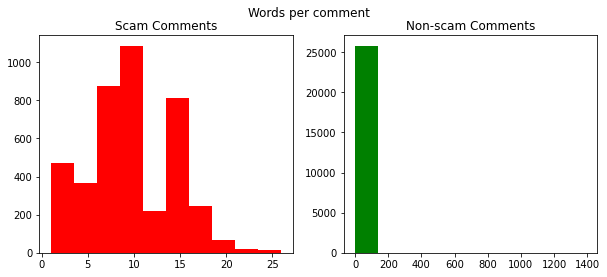

In [10]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train[train['Is Scam']==1]['Word Count']
ax1.hist(train_words,color='red')
ax1.set_title('Scam Comments')
train_words=train[train['Is Scam']==0]['Word Count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-scam Comments')
fig.suptitle('Words per comment')
plt.show()

In [20]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = str(text).lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))


train['Clean Comment'] = train['Comments'].apply(lambda x: finalpreprocess(x))
train['Clean Username'] = train['Author'].apply(lambda x : finalpreprocess(x))

In [21]:
train.head()

,Comments,Is Reply,Author,Is Scam,Word Count,Clean Comment,Clean text tokens,Clean Username
0,I hope you guys like the new video concept :),False,MrBeast,0,10,hope guy like new video concept,"[hope, guy, like, new, video, concept]",mrbeast
1,your mom,True,ry kb,0,2,mom,[mom],ry kb
2,Y r best,True,Debashis Bhattacharjee,0,3,r best,"[r, best]",debashis bhattacharjee
3,Last,True,Niloy Zaman,0,1,last,[last],niloy zaman
4,I love you,True,RedTune605,0,3,love,[love],redtune


In [26]:
train['Clean text tokens']=[nltk.word_tokenize(i) for i in train['Clean Comment']]
train['Clean Username tokens'] = [nltk.word_tokenize(i) for i in train['Clean Username']]

X_train, X_test, y_train, y_test = train_test_split(train['Clean Comment'], train['Is Scam'], test_size=0.4, shuffle=True)
X_train_author, X_test_author, y_train_author, y_test_author = train_test_split(train['Clean Username'], train['Is Scam'], test_size=0.4, shuffle=True)

In [27]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

X_train_author_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train_author)
X_test_author_vectors_tfidf = tfidf_vectorizer.transform(X_test_author)

In [28]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10351
           1       0.68      0.63      0.65      1649

    accuracy                           0.91     12000
   macro avg       0.81      0.79      0.80     12000
weighted avg       0.91      0.91      0.91     12000

Confusion Matrix: [[9850  501]
 [ 606 1043]]
AUC: 0.9458337695581276


In [29]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_author_vectors_tfidf, y_train_author)  #model

y_predict_author = lr_tfidf.predict(X_test_author_vectors_tfidf)
y_prob_author = lr_tfidf.predict_proba(X_test_author_vectors_tfidf)[:,1]

print(classification_report(y_test_author,y_predict_author))
print('Confusion Matrix:',confusion_matrix(y_test_author, y_predict_author))

fpr, tpr, thresholds = roc_curve(y_test_author, y_prob_author)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10359
           1       0.79      0.67      0.72      1641

    accuracy                           0.93     12000
   macro avg       0.87      0.82      0.84     12000
weighted avg       0.93      0.93      0.93     12000

Confusion Matrix: [[10064   295]
 [  541  1100]]
AUC: 0.9740646559389343


In [25]:
#Pre-processing the new dataset
test['Clean Comments'] = test['Comments'].apply(lambda x: finalpreprocess(x)) #preprocess the data
test['Clean Username'] = test['Author'].apply(lambda x: finalpreprocess(x)) #preprocess the data

X_test=test['Clean Comments']
X_test_author = test['Clean Username']
#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)
X_vector_author = tfidf_vectorizer.transform(X_test_author)
#use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]

y_predict_author = lr_tfidf.predict(X_vector_author)      
y_prob_author = lr_tfidf.predict_proba(X_vector_author)[:,1]

test['predict_prob']= y_prob
test['Is Scam']= y_predict
test['author_predict_prob'] = y_prob_author
test['Is Scam _author'] = y_predict_author
final=test[['Clean Comments', 'Clean Username', 'predict_prob', 'author_predict_prob', 'Is Scam', 'Is Scam _author']].reset_index(drop=True)

In [19]:
final[final['Is Scam'] == True]

,Clean Comments,predict_prob,Is Scam
283,thanks watch leave comment telegram claim prize,0.606628,1
422,winnerdm claim prize telegram,0.833292,1
441,winnerdm claim prize telegram,0.833292,1
444,winnerdm claim prize telegram,0.833292,1
460,winnerdm claim prize telegram,0.833292,1
...,...,...,...
4948,thanks watch select among lucky winner inbox,0.850595,1
4952,thanks watch select among lucky winner inbox,0.850595,1
4954,thanks watch select among lucky winner inbox,0.850595,1
4959,thanks watch select among lucky winner inbox,0.850595,1
